![logo.JPG](data/img/logo.JPG)

In [517]:
# Importation des librairies python spécialisées dans le Jupyter Notebook
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [518]:
# Affiche la taille du jeu de données
def displayDataShape(data):
    shape = data.shape
    print(f"Le jeu de données contient : {shape[0]} lignes et {shape[1]} colonnes\n")

# Affichage des Nan en %
def displayNanPercent(data):
    missing_values = pd.DataFrame((data.isna().mean()*100).sort_values())
    missing_values.columns = ['Valeurs manquantes en %']
    return missing_values

# Retourne le data en filtrant par % de NaN dans les colonnes
def filterDataColumnByNan(data, limit_nan=0.75):
    return data[data.columns[data.isna().mean() <= limit_nan]].copy()

# Retourne le data en filtrant par % de Nan dans les lignes, filtré par colonnes contenant la mention "_100g" (quantité d'un nutriment pour 100g du produit)
def filterDataRowByNan(data, limit_nan=1):
    nutriment_amount_tag = "_100g"
    data_columns_filtered = data[[col for col in data.columns if col.endswith(nutriment_amount_tag)]]
    index_with_nan = data_columns_filtered.index[data_columns_filtered.isnull().mean(axis=1) == limit_nan]

    return data.drop(index=index_with_nan).copy()

# Retourne le data en filtrant les lignes qui ont des valeurs à NaN dans la colonne passée en paramètre
def filterDataRowByNanInColumn(data, column_name):
    return data[data[column_name].notna()].copy()

# Affiche le nombre de valeurs uniques pour chaque colonne dans le tableau passé en paramètres
def displayNbrUnique(data, columns):
    if type(data) != type(pd.DataFrame()):
        raise ValueError(f"data n\'est pas un DataFrame, mais est de type {type(data)}!")

    nbr_uniques = []

    for column in columns:
        nbr_uniques.append(data[column].nunique())

    return pd.Series(nbr_uniques, index=columns)

# Retourne 2 tableaux contenant les noms des variables quantitatives et qualitatives
def categoriseVariables(data):
    infos_type = data.dtypes
    quantitative_columns = []
    qualitative_columns = []

    for index in infos_type.index:
        if (infos_type[index] == 'float') | (infos_type[index] == 'int'):
            quantitative_columns.append(index)
        else:
            qualitative_columns.append(index)

    return quantitative_columns, qualitative_columns

def lowerStringInColumns(data, columns):
    new_data = data.copy()
    for column in columns:
        new_data[column] = new_data[column].str.lower()

    return new_data

def cleanDataOutInterval(data, columns, min, max):
    for column in columns:
        if "_100g" in column and "energy" not in column and "score" not in column:
            data[column] = data[column].apply(replaceMinMaxInColumn, args=(min, max, np.nan))

    return data.copy()

def cleanZeroValuesInData(data, columns):
    for column in columns:
        data[column] = data[column].apply(replaceValuesInColumn, args=(0, np.nan))

    return data.copy()

def replaceMinMaxInColumn(value, min, max, new_value):
    if (value < min) | (value > max):
        value = new_value
    return value

def cleanDataQuali(data, columns, old_value, new_value):
    for column in columns:
        data[column] = data[column].apply(replaceValuesInColumn, args=(old_value, new_value))

    return data

def replaceValuesInColumn(value, old_value, new_value):
    if value == old_value:
        value = new_value

    return value

def removeOutliers(data, columns):
    Q1 = data[columns].quantile(0.25)
    Q3 = data[columns].quantile(0.75)
    EI = Q3 - Q1

    outliers = (data[columns] >= (Q1 - 1.5 * EI)) & (data[columns] <= (Q3 + 1.5 * EI))

    return outliers

def drawHist(data, columns, dims_fig):
    nbr_rows = int(len(columns)/3) + 1
    index = 1
    plt.figure(figsize=dims_fig)
    for column in columns:
        plt.subplot(nbr_rows, 3, index)
        plt.hist(data[column])
        plt.xlabel(f"{column}")
        plt.ylabel("Nombre d'aliments")
        plt.title(f"Histogramme - {column}")
        index += 1
    plt.show()

def drawBoxPlot(data, columns, dims_fig):
    nbr_rows = int(len(columns)/3) + 1
    index = 1
    plt.figure(figsize=dims_fig)
    for column in columns:
        plt.subplot(nbr_rows, 3, index)
        sns.boxplot(x=data[column])
        plt.xlabel(column)
        plt.title(f"Boite à moustaches pour {column}")
        index += 1
    plt.show()

def drawPieplot(data, columns, dims_fig):
    nbr_rows = int(len(columns)/2) + 1
    index = 1
    #plt.figure(figsize=dims_fig)
    for column in columns:
        values_name = data[column].value_counts().index
        data_sum = data[column].value_counts()
        iteration = 0
        for value in values_name:
            if iteration >= 30:
                break
            elif data_sum[value]/data_sum.sum()*100 >= 1.5:
                iteration+= 1
            else:
                break

        data_bis = data[column].where(data[column].isna() | data[column].isin(data[column].value_counts().index[:iteration]), other='other')

        if 'other' not in data_bis.value_counts().index:
            plt.subplot(nbr_rows, 2, index)
            data_bis.value_counts().plot.pie(figsize=dims_fig,
                                                autopct='%1.1f%%',
                                                startangle = 60,
                                                rotatelabels = True,
                                                pctdistance = 0.85)
            plt.ylabel("Nombre d'aliments")
            plt.title(f"Répartition des aliments par {column}", pad=50)
            index += 1
        elif data_bis.value_counts()['other']/data_bis.value_counts().sum()*100 < 60:
            plt.subplot(nbr_rows, 2, index)
            data_bis.value_counts().plot.pie(figsize=dims_fig,
                                             autopct='%1.1f%%',
                                             startangle = 60,
                                             rotatelabels = True,
                                             pctdistance = 0.85)
            plt.ylabel("Nombre d'aliments")
            plt.title(f"Répartition des aliments par {column}", pad=50)
            index += 1
    plt.show

# Affiche les informations supprimées entre le data et le data nettoyé
def displayInfosDataCleaned(data, data_cleaned):
    print(f"Nombre de lignes supprimées : {data.shape[0] - data_cleaned.shape[0]}")
    print(f"Nombre de colonnes supprimées : {data.shape[1] - data_cleaned.shape[1]}")
    print(f"Colonnes supprimées : {[col for col in data.columns if col not in data_cleaned.columns]}\n")
    displayDataShape(data_cleaned)

In [519]:
data = pd.read_csv("data/fr.openfoodfacts.org.products.csv", sep='\t', low_memory=False)
displayDataShape(data)

Le jeu de données contient : 320772 lignes et 162 colonnes



<AxesSubplot:>

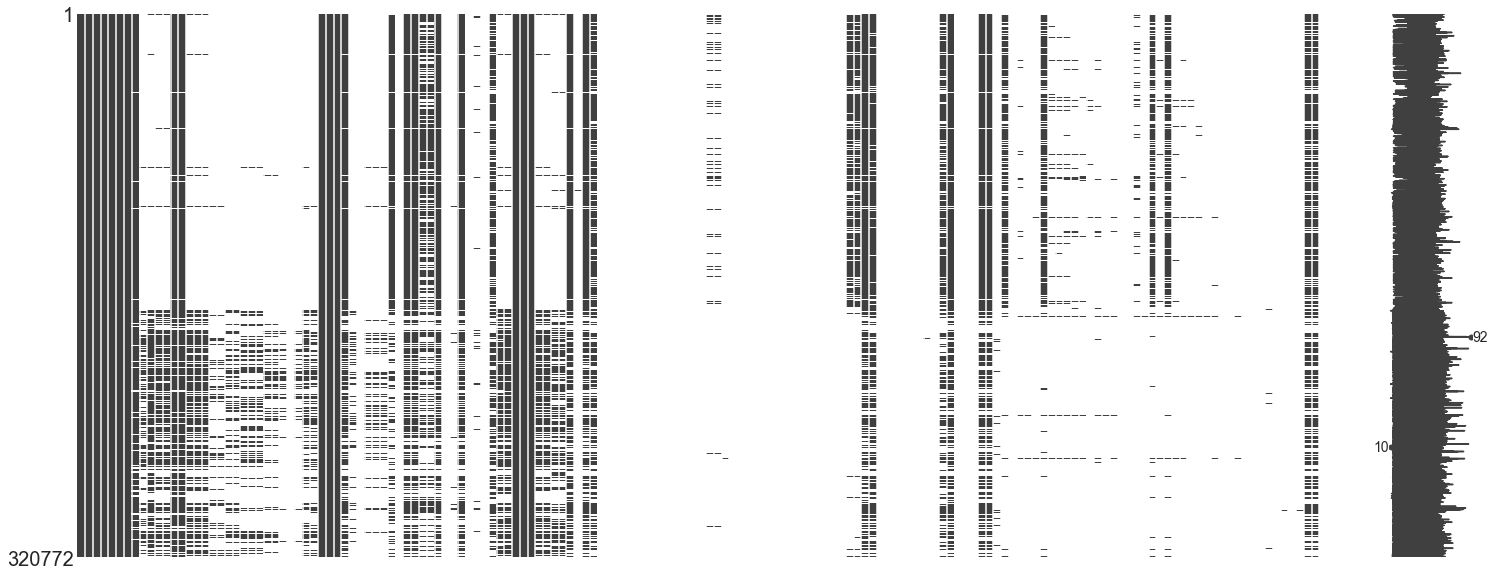

In [520]:
msno.matrix(data)

In [521]:
data_cleaned = filterDataColumnByNan(data)

In [522]:
data_cleaned = filterDataRowByNan(data_cleaned)

In [523]:
data_cleaned = filterDataRowByNanInColumn(data_cleaned, 'code')

In [524]:
data_cleaned = filterDataRowByNanInColumn(data_cleaned, 'product_name')

In [525]:
displayInfosDataCleaned(data, data_cleaned)

Nombre de lignes supprimées : 61338
Nombre de colonnes supprimées : 112
Colonnes supprimées : ['generic_name', 'packaging', 'packaging_tags', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'no_nutriments', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'image_url', 'image_small_url', 'energy-from-fat_100g', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100g', 'melissic-acid_100g', 'monounsatura

In [526]:
data_cleaned[data_cleaned.duplicated(['code','product_name'])].sort_values('code')

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g


<AxesSubplot:>

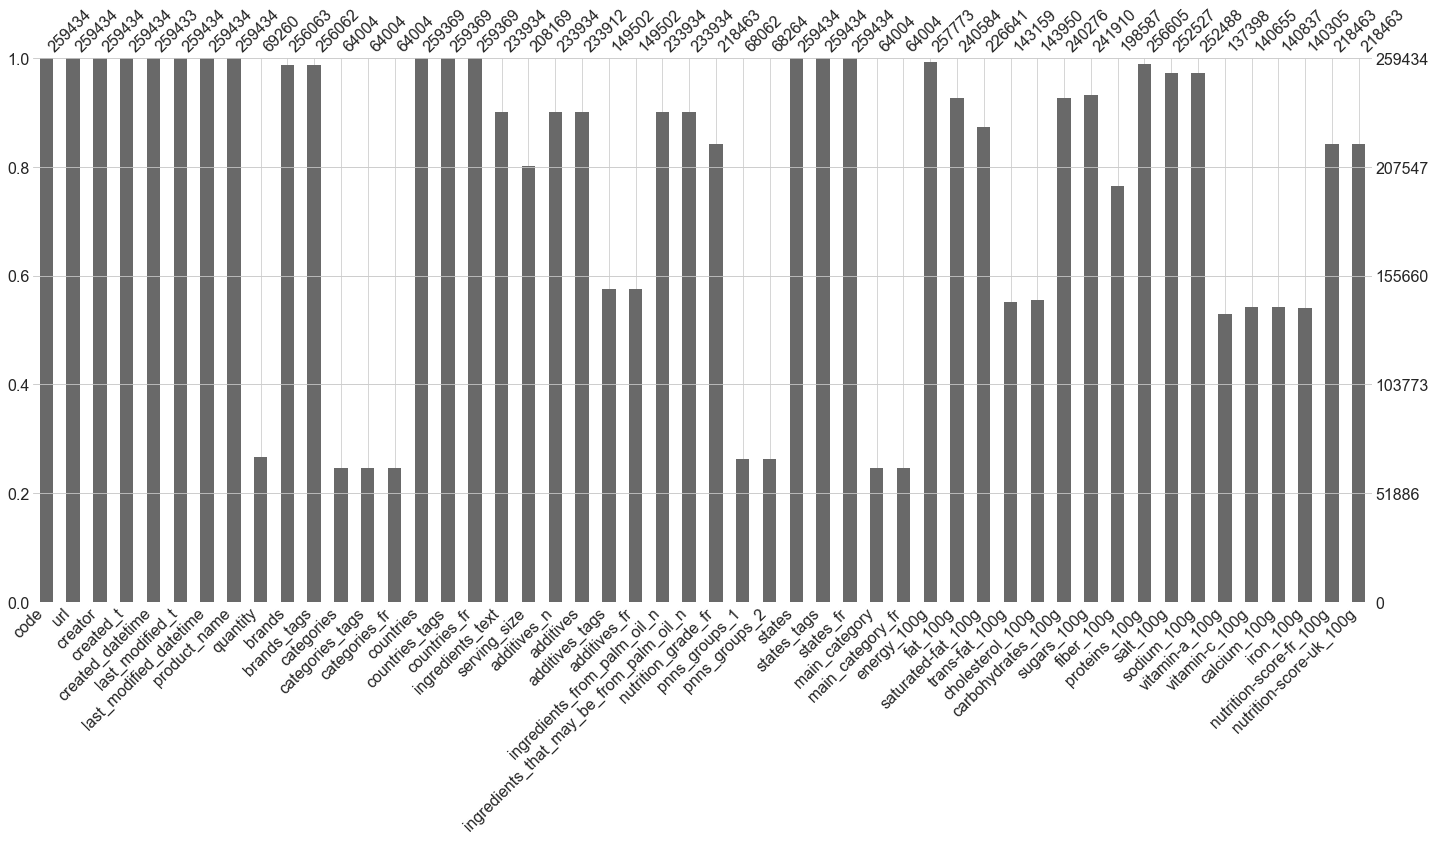

In [527]:
msno.bar(data_cleaned)

In [528]:
data_cleaned.head(20)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,3.6,3.57,0.00000,0.000,0.000000,0.0214,0.000,0.00129,14.0,14.0
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,Torn & Glasser,...,7.1,17.86,0.63500,0.250,0.000000,0.0000,0.071,0.00129,0.0,0.0
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,Grizzlies,...,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0,12.0
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,Bob's Red Mill,...,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0000000016100,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,NaN,Unfi,...,7.7,13.46,NaN,NaN,NaN,NaN,0.038,0.00346,NaN,NaN
6,0000000016117,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055730,2017-03-09T10:35:30Z,1489055730,2017-03-09T10:35:30Z,Organic Long Grain White Rice,NaN,Lundberg,...,NaN,8.89,NaN,NaN,NaN,0.0027,0.044,NaN,NaN,NaN
7,0000000016124,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055711,2017-03-09T10:35:11Z,1489055712,2017-03-09T10:35:12Z,Organic Muesli,NaN,Daddy's Muesli,...,9.4,14.06,0.13970,0.055,NaN,NaN,0.062,0.00422,7.0,7.0
8,0000000016193,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Organic Dark Chocolate Minis,NaN,Equal Exchange,...,7.5,5.00,NaN,NaN,NaN,NaN,0.050,0.01125,NaN,NaN
9,0000000016513,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055654,2017-03-09T10:34:14Z,1489055654,2017-03-09T10:34:14Z,Organic Sunflower Oil,NaN,Napa Valley Naturals,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0000000016612,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Adzuki Beans,NaN,Unfi,...,12.5,22.92,NaN,NaN,NaN,NaN,0.062,0.00450,NaN,NaN


In [529]:
quanti,quali = categoriseVariables(data_cleaned)
print(f"Variables quantitatives: \n{quanti}\n")
print(f"Variables qualitatives: \n{quali}")

Variables quantitatives: 
['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']

Variables qualitatives: 
['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'serving_size', 'additives', 'additives_tags', 'additives_fr', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_fr', 'main_category', 'main_category_fr']


Pour les variables qualitatives on ne va garder que les colonnes suivantes :
- product_name
- nutrition_grade_fr
- pnns_groups_1
- pnns_groups_2
- main_category

In [530]:
quali = ['product_name', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'main_category']

In [531]:
data_cleaned[quali]

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,main_category
1,Banana Chips Sweetened (Whole),d,NaN,NaN,NaN
2,Peanuts,b,NaN,NaN,NaN
3,Organic Salted Nut Mix,d,NaN,NaN,NaN
4,Organic Polenta,NaN,NaN,NaN,NaN
5,Breadshop Honey Gone Nuts Granola,NaN,NaN,NaN,NaN
...,...,...,...,...,...
320756,Test NF App,NaN,NaN,NaN,NaN
320757,Amandes,b,NaN,NaN,NaN
320763,Thé vert Earl grey,c,Beverages,Non-sugared beverages,en:green-teas
320768,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",b,NaN,NaN,NaN


In [532]:
data_cleaned = lowerStringInColumns(data_cleaned, quali)
data_cleaned = cleanDataQuali(data_cleaned, quali, "unknown", np.nan)
data_cleaned[quali]

,product_name,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,main_category
1,banana chips sweetened (whole),d,NaN,NaN,NaN
2,peanuts,b,NaN,NaN,NaN
3,organic salted nut mix,d,NaN,NaN,NaN
4,organic polenta,NaN,NaN,NaN,NaN
5,breadshop honey gone nuts granola,NaN,NaN,NaN,NaN
...,...,...,...,...,...
320756,test nf app,NaN,NaN,NaN,NaN
320757,amandes,b,NaN,NaN,NaN
320763,thé vert earl grey,c,beverages,non-sugared beverages,en:green-teas
320768,"mint melange tea a blend of peppermint, lemon ...",b,NaN,NaN,NaN


In [533]:
displayNbrUnique(data_cleaned, quali)

product_name          183134
nutrition_grade_fr         5
pnns_groups_1             13
pnns_groups_2             36
main_category           2355
dtype: int64

In [534]:
# Réglage des graphiques

plt.style.use('seaborn-whitegrid')

plt.rc('font', size=12)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

dims_fig = (25,35)

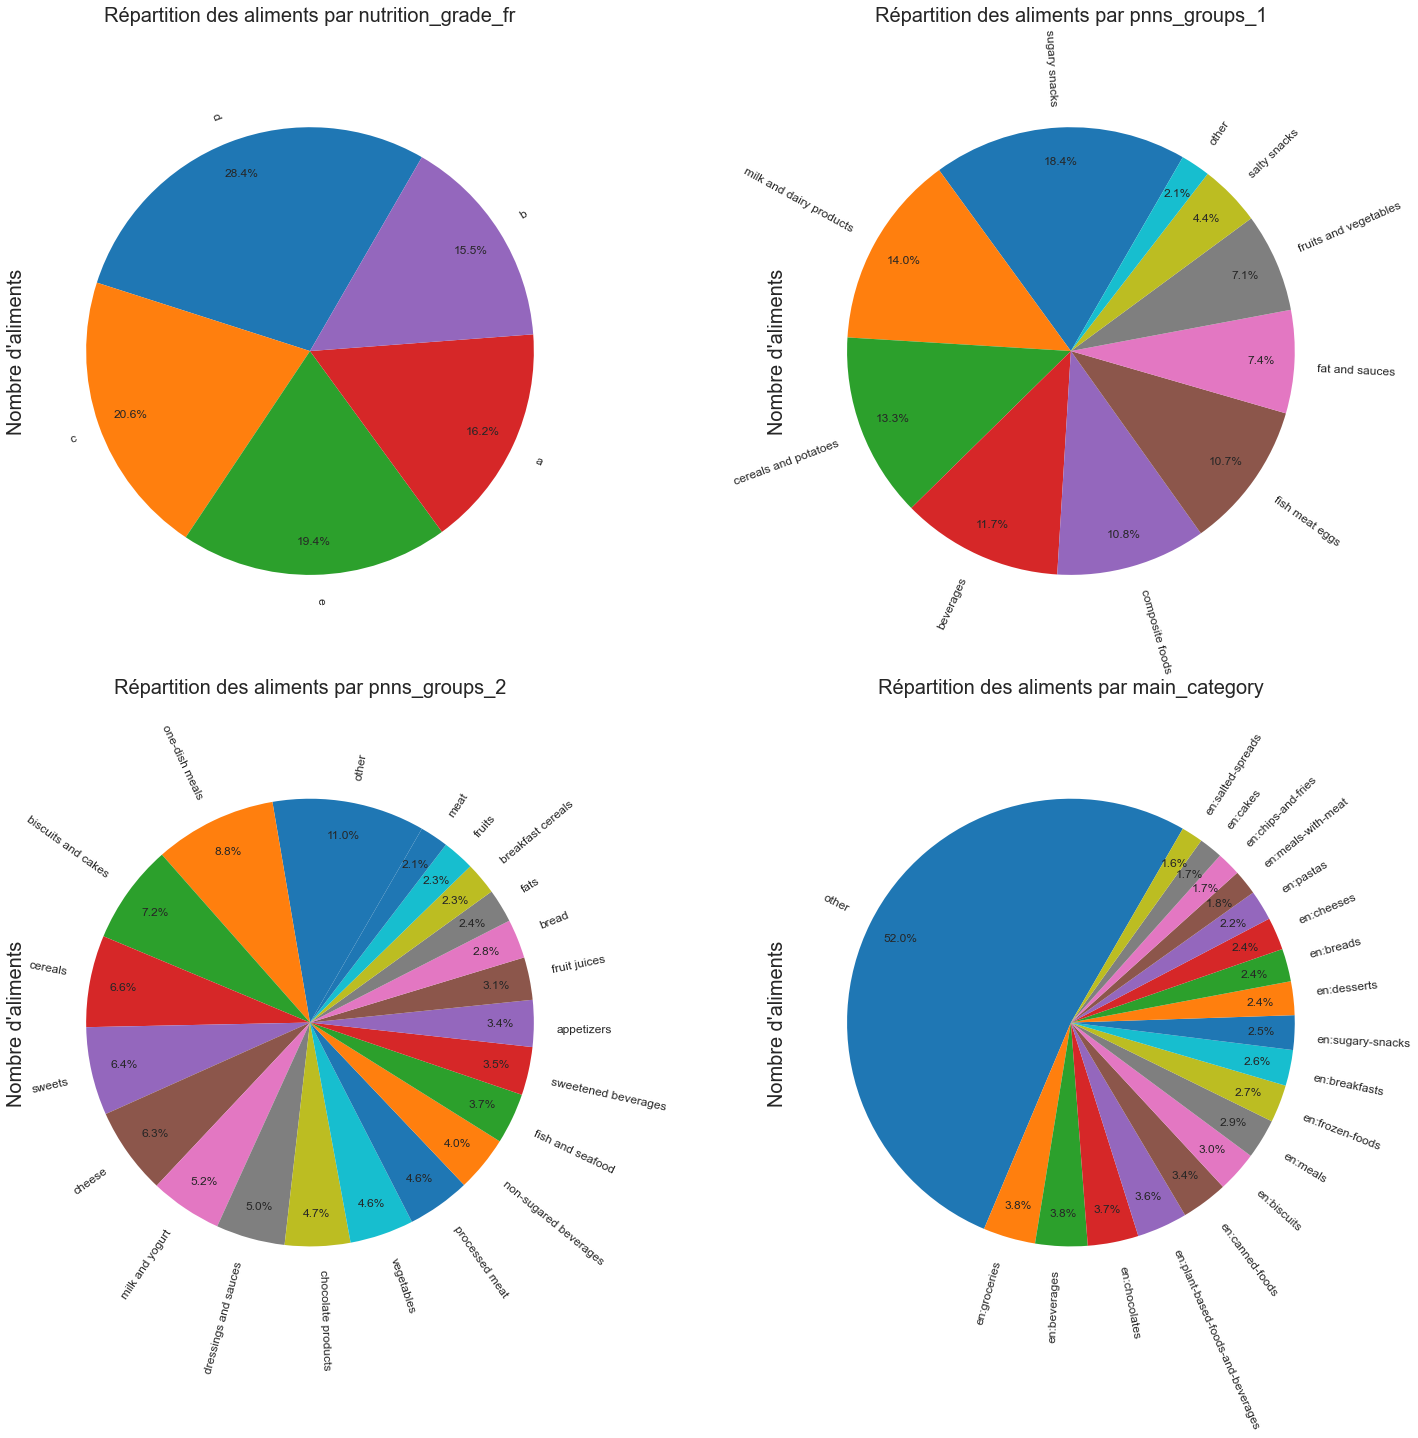

In [535]:
drawPieplot(data_cleaned, quali, dims_fig)

In [536]:
data_cleaned[quanti].describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,233934.000000,233934.000000,233934.000000,2.577730e+05,240584.000000,226641.000000,143159.000000,143950.000000,240276.000000,241910.000000,198587.000000,256605.000000,252527.000000,252488.000000,137398.000000,140655.00000,140837.000000,140305.000000,218463.000000,218463.000000
mean,1.994161,0.018779,0.054721,1.140497e+03,12.701388,5.115709,0.073428,0.020079,32.091647,15.993129,2.863581,7.074330,2.037957,0.802467,0.000397,0.02335,0.125119,0.003654,9.151724,9.044406
std,2.516437,0.137433,0.266629,6.484434e+03,17.574028,8.008095,1.540612,0.358234,29.765368,22.345150,12.933636,8.418758,129.023620,50.800621,0.073320,2.23813,3.320757,0.214528,9.052588,9.180977
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-3.570000,0.000000,0.000000,-17.860000,-6.700000,-800.000000,0.000000,0.000000,-0.000340,-0.00210,0.000000,-0.000260,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,3.730000e+02,0.000000,0.000000,0.000000,0.000000,6.000000,1.300000,0.000000,0.700000,0.063500,0.025000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,1.100000e+03,5.000000,1.790000,0.000000,0.000000,20.600000,5.710000,1.500000,4.760000,0.584200,0.230000,0.000000,0.00000,0.035000,0.001010,10.000000,9.000000
75%,3.000000,0.000000,0.000000,1.674000e+03,20.000000,7.140000,0.000000,0.020000,58.500000,24.000000,3.600000,10.000000,1.379220,0.543000,0.000107,0.00370,0.106000,0.002400,16.000000,16.000000
max,31.000000,2.000000,6.000000,3.251373e+06,714.290000,550.000000,369.000000,95.238000,2916.670000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000,26.700000,716.98110,694.737000,50.000000,40.000000,40.000000


Suppression des valeurs en dessous de 0 et au dessous de 100 pour les colonnes suivantes :
- fat_100g
- saturated-fat_100g
- trans-fat_100g
- cholesterol_100g
- carbohydrates_100g
- sugars_100g
- fiber_100g
- proteins_100g
- salt_100g
- sodium_100g
- vitamin-a_100g
- vitamin-c_100g
- calcium_100g
- iron_100g

In [537]:
data_cleaned = cleanDataOutInterval(data_cleaned, quanti, 0, 100)

Suppression des outliers par la méthode de l'écart inter-quartiles, pour les colonnes suivantes :
- energy_100g
- nutrition-score-fr_100g
- nutrition-score-uk_100g


In [538]:
outliers = removeOutliers(data_cleaned, ['energy_100g','nutrition-score-fr_100g','nutrition-score-uk_100g'])
data_cleaned[['energy_100g','nutrition-score-fr_100g','nutrition-score-uk_100g']] = data_cleaned[['energy_100g','nutrition-score-fr_100g','nutrition-score-uk_100g']][outliers]
data_cleaned.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,233934.000000,233934.000000,233934.000000,256709.000000,240580.000000,226638.000000,143150.000000,143950.000000,240258.00000,241892.000000,198582.000000,256601.000000,252371.000000,252454.000000,137397.000000,140651.000000,140827.000000,140304.000000,218459.000000,218460.000000
mean,1.994161,0.018779,0.054721,1113.395627,12.696195,5.111649,0.067118,0.020079,32.07302,15.975216,2.833600,7.077845,1.593437,0.649009,0.000397,0.014532,0.101944,0.003654,9.151159,9.043981
std,2.516437,0.137433,0.266629,781.536587,17.497914,7.906154,0.944894,0.358234,29.16708,21.169760,4.591686,8.163246,6.261328,2.663027,0.073320,0.461745,0.585645,0.214529,9.051708,9.180323
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,372.000000,0.000000,0.000000,0.000000,0.000000,6.00000,1.300000,0.000000,0.700000,0.063500,0.025000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,1093.000000,5.000000,1.790000,0.000000,0.000000,20.59000,5.710000,1.500000,4.760000,0.584200,0.230000,0.000000,0.000000,0.035000,0.001010,10.000000,9.000000
75%,3.000000,0.000000,0.000000,1674.000000,20.000000,7.140000,0.000000,0.020000,58.45750,24.000000,3.600000,10.000000,1.374140,0.543000,0.000107,0.003700,0.106000,0.002400,16.000000,16.000000
max,31.000000,2.000000,6.000000,3619.000000,100.000000,100.000000,100.000000,95.238000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,26.700000,100.000000,99.006000,50.000000,38.000000,38.000000


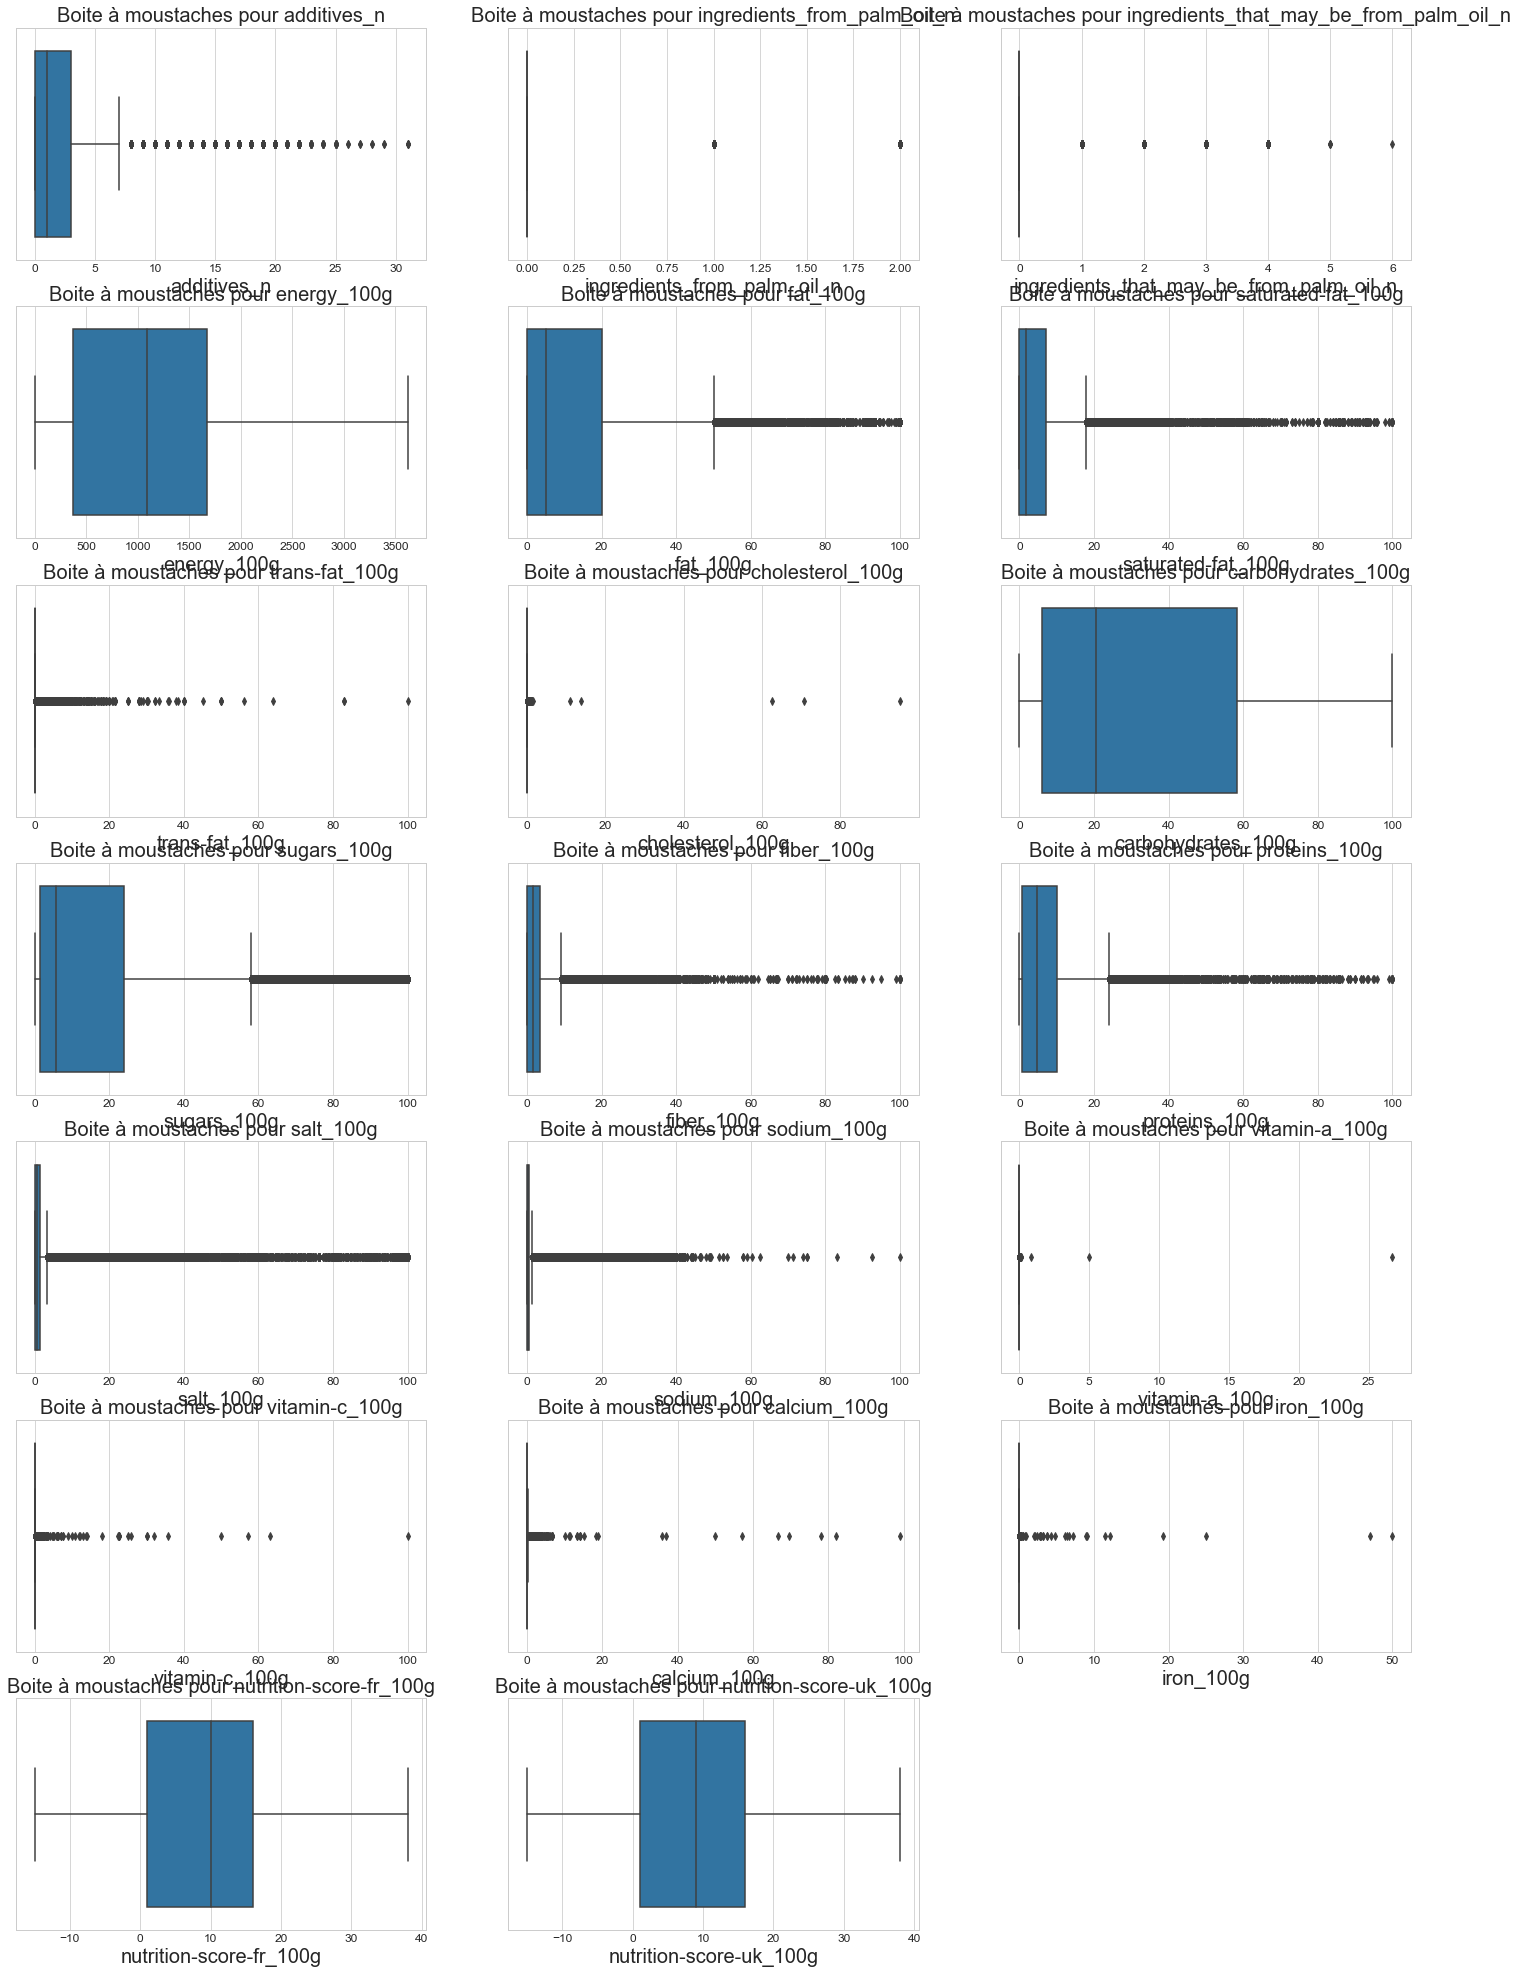

In [539]:
drawBoxPlot(data_cleaned, quanti, dims_fig)

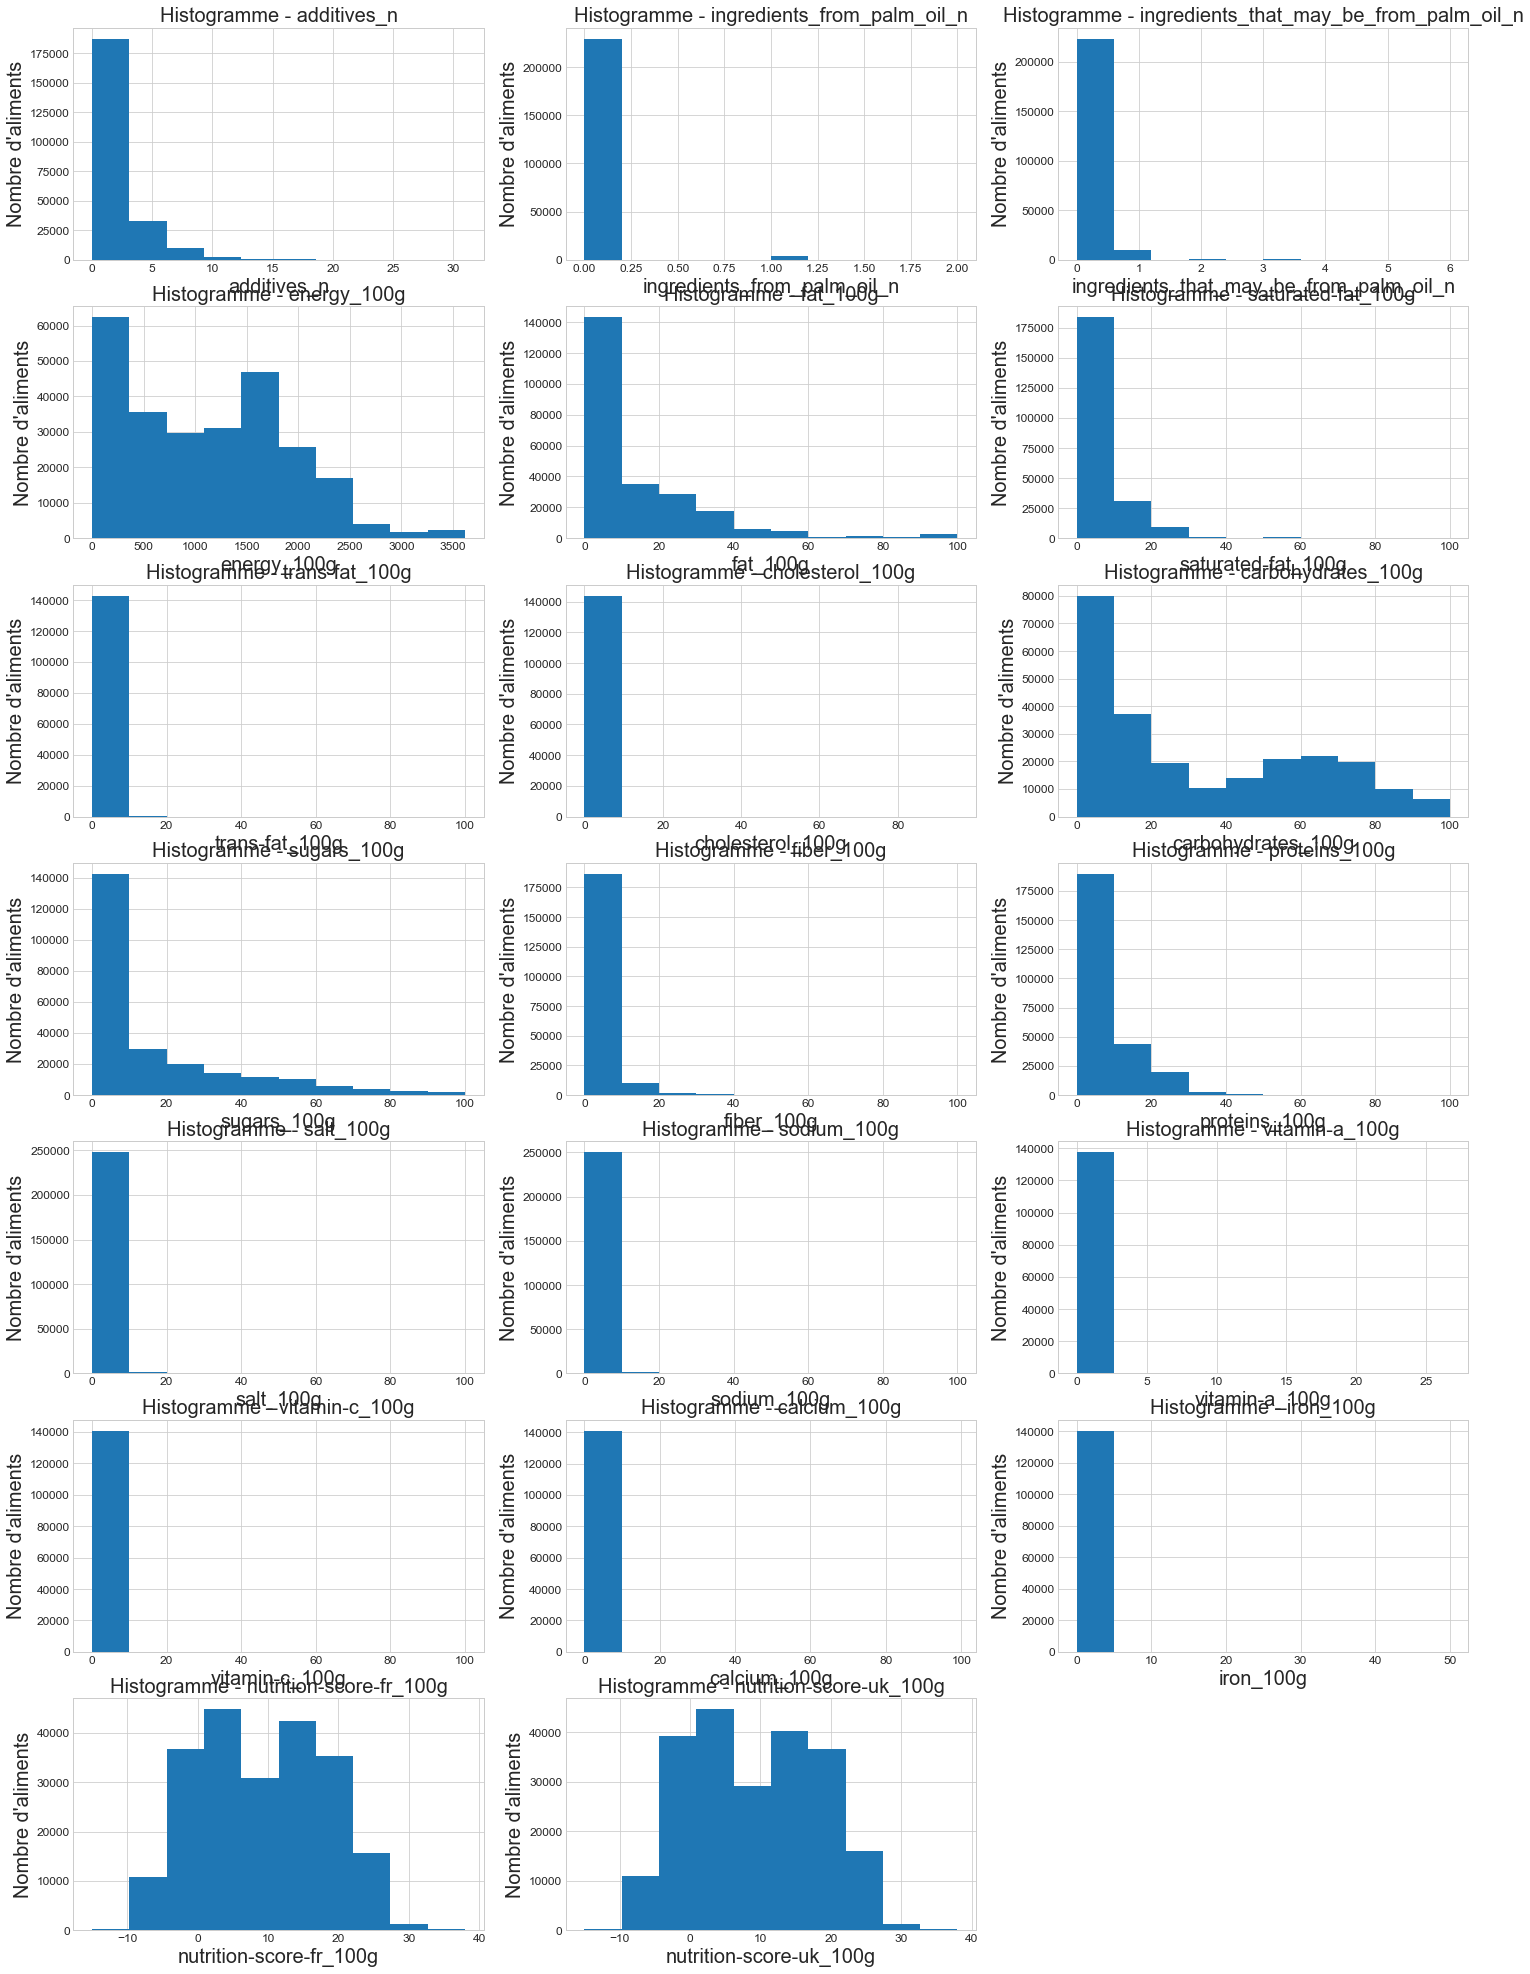

In [540]:
drawHist(data_cleaned, quanti, dims_fig)

Les données nutritionnelles principales sont :
- **fat_100g** (lipides), décliné ensuite par les données :
    - saturated-fat_100g
    - trans-fat_100g
    - cholesterol_100g
- **carbohydrates_100g** (glucides), décliné ensuite par les données :
    - sugars_100g
    - fiber_100g
- **proteins_100g** (protéines)

Ces données principales servent à calculer :
- **energy_100g**

Le calcul des calories d'un aliment s'effectue selon un processus normalisé au niveau européen et baptisé système « 4/4/9 »
Ce système implique que l'équivalent calorique d'un gramme de **protéines**, de **glucides** et de **lipides** - nos trois principaux « carburants » nutritionnels - correspond respectivement à **4, 4 et 9 kcal**.

1 gr de proteine apporte 4 kcal
1 gr de glucide (carbohydrate) apporte 4 kcal
1 gr de lipide apporte 9 kcal

In [541]:
nutri = ['energy_100g','fat_100g', 'carbohydrates_100g', 'proteins_100g', 'nutrition_grade_fr']
data_cleaned[nutri].shape[0]

sum_nutritional_elements = []
energy_calculated = []

for index in range(data_cleaned[nutri].shape[0]):
    value_sum = data_cleaned['fat_100g'].iloc[index] + data_cleaned['carbohydrates_100g'].iloc[index] + data_cleaned['proteins_100g'].iloc[index]
    value_energy = (data_cleaned['fat_100g'].iloc[index]*9 + data_cleaned['carbohydrates_100g'].iloc[index]*4 + data_cleaned['proteins_100g'].iloc[index]*4)*4.187

    sum_nutritional_elements.append(value_sum)
    energy_calculated.append(value_energy)

data_cleaned['sum_nutritional_elements_100g'] = sum_nutritional_elements
data_cleaned['energy_calculated_100g'] = energy_calculated
data_cleaned['energy_difference'] = abs(data_cleaned['energy_100g'] - data_cleaned['energy_calculated_100g'])

data_cleaned[['sum_nutritional_elements_100g', 'energy_calculated_100g', 'energy_difference']].describe()

,sum_nutritional_elements_100g,energy_calculated_100g,energy_difference
count,238411.000000,238411.000000,237191.000000
mean,51.698274,1130.291358,59.553247
std,33.917433,812.105339,146.763682
min,0.000000,0.000000,0.000000
25%,19.250000,363.054770,7.644560
50%,50.000000,1108.424510,22.745000
75%,87.000000,1674.800000,57.127860
max,233.340000,6001.478320,4187.125610


In [542]:
data_cleaned = data_cleaned[data_cleaned['sum_nutritional_elements_100g'] <= 100]
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236587 entries, 1 to 320771
Data columns (total 53 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     236587 non-null  object 
 1   url                                      236587 non-null  object 
 2   creator                                  236587 non-null  object 
 3   created_t                                236587 non-null  object 
 4   created_datetime                         236586 non-null  object 
 5   last_modified_t                          236587 non-null  object 
 6   last_modified_datetime                   236587 non-null  object 
 7   product_name                             236587 non-null  object 
 8   quantity                                 63287 non-null   object 
 9   brands                                   233440 non-null  object 
 10  brands_tags                     

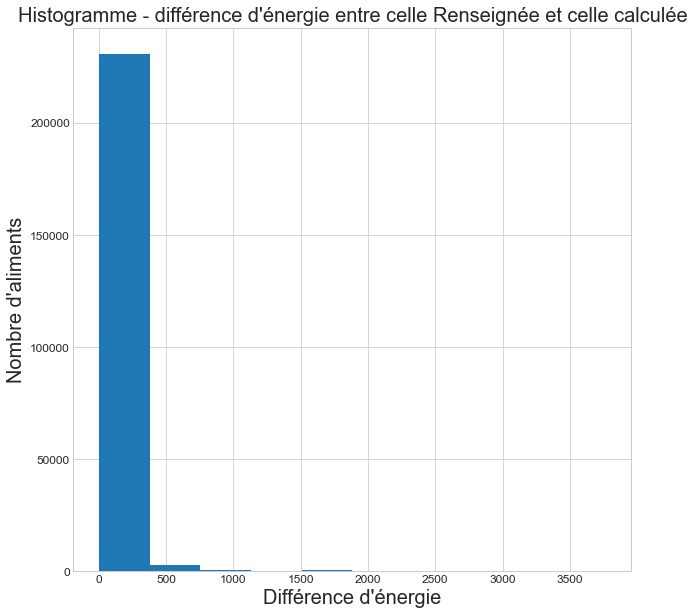

In [543]:
plt.figure(figsize=(10,10))
plt.hist(data_cleaned['energy_difference'])
plt.xlabel("Différence d'énergie")
plt.ylabel("Nombre d'aliments")
plt.title("Histogramme - différence d'énergie entre celle Renseignée et celle calculée")
plt.show()

In [545]:
data_cleaned = data_cleaned[data_cleaned['energy_difference'] <= 500]
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232434 entries, 1 to 320768
Data columns (total 53 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     232434 non-null  object 
 1   url                                      232434 non-null  object 
 2   creator                                  232434 non-null  object 
 3   created_t                                232434 non-null  object 
 4   created_datetime                         232433 non-null  object 
 5   last_modified_t                          232434 non-null  object 
 6   last_modified_datetime                   232434 non-null  object 
 7   product_name                             232434 non-null  object 
 8   quantity                                 62276 non-null   object 
 9   brands                                   229523 non-null  object 
 10  brands_tags                     

In [550]:
data_cleaned.drop(columns=['sum_nutritional_elements_100g', 'energy_calculated_100g', 'energy_difference'])

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,banana chips sweetened (whole),NaN,NaN,...,3.6,3.57,0.00000,0.000000,0.0,0.0214,0.000,0.00129,14.0,14.0
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,peanuts,NaN,Torn & Glasser,...,7.1,17.86,0.63500,0.250000,0.0,0.0000,0.071,0.00129,0.0,0.0
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,organic salted nut mix,NaN,Grizzlies,...,7.1,17.86,1.22428,0.482000,NaN,NaN,0.143,0.00514,12.0,12.0
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,organic polenta,NaN,Bob's Red Mill,...,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0000000016100,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,breadshop honey gone nuts granola,NaN,Unfi,...,7.7,13.46,NaN,NaN,NaN,NaN,0.038,0.00346,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320742,9787461062105,http://world-fr.openfoodfacts.org/produit/9787...,usda-ndb-import,1489092300,2017-03-09T20:45:00Z,1489092300,2017-03-09T20:45:00Z,natural cassava,NaN,Industria De Casabe Paul,...,4.7,1.18,0.03048,0.012000,0.0,0.0000,0.000,0.00127,-1.0,-1.0
320750,9836654056565,http://world-fr.openfoodfacts.org/produit/9836...,usda-ndb-import,1489055289,2017-03-09T10:28:09Z,1489055289,2017-03-09T10:28:09Z,raspados ice bars,NaN,"Jarritos, The Jel Sert Company",...,NaN,0.00,0.04572,0.018000,NaN,NaN,NaN,NaN,NaN,NaN
320751,9847548283004,http://world-fr.openfoodfacts.org/produit/9847...,drmalabar,1437817626,2015-07-25T09:47:06Z,1442237848,2015-09-14T13:37:28Z,tartines craquantes bio au sarrasin,NaN,Le Pain des fleurs,...,5.9,13.00,0.68000,0.267717,NaN,NaN,NaN,0.00380,-4.0,-4.0
320763,99111250,http://world-fr.openfoodfacts.org/produit/9911...,balooval,1367163039,2013-04-28T15:30:39Z,1371690556,2013-06-20T01:09:16Z,thé vert earl grey,50 g,Lobodis,...,0.2,0.50,0.02540,0.010000,NaN,NaN,NaN,NaN,2.0,0.0


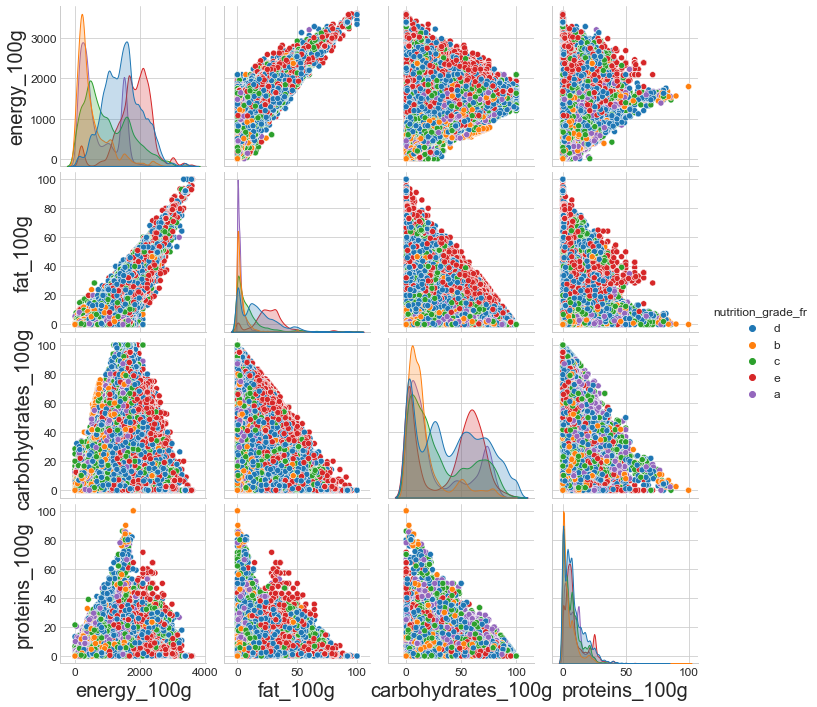

In [557]:
sns.pairplot(data_cleaned[nutri], hue='nutrition_grade_fr')
plt.show()